In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
from kalman import Kalman, LDS

# Test Reference Kalman Filter

Kalman filter exclusive of nengo

In [2]:
def run_lds_kf(lds, kf, steps, u=0):
    """Run an experiment with a linear dynamical system and a Kalman filter"""
    lds_x = np.zeros((steps, lds.state_dimensions))
    lds_y = np.zeros((steps, lds.output_dimensions))
    kf_xhat = np.zeros((steps, lds.state_dimensions))
    kf_p = np.zeros((steps, lds.state_dimensions, lds.state_dimensions))
    kf_k = np.zeros((steps, lds.state_dimensions, lds.output_dimensions))
    
    lds_x[0, :], lds_y[0, :] = lds.initial_condition
    kf_xhat[0, :] = kf.xhat
    kf_p[0, :] = kf.p
    for step in range(steps)[1:]:
        lds_x[step, :], lds_y[step, :] = lds.step(u)
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(u, lds_y[step, :])
    kf_k[0, :] = kf_k[1, :]
    lds_data = (lds_x, lds_y)
    kf_data = (kf_xhat, kf_p, kf_k)
    return lds_data, kf_data

def plot_lds_kf_1d(lds_data, kf_data):
    fig, axs = plt.subplots(nrows=3, figsize=(8, 6))
    x, y = lds_data
    xhat, p, k = kf_data
    axs[0].plot(x, 'k', label="truth")
    axs[0].plot(y, '+', label="measurements")
    axs[0].plot(xhat, 'k--', label="estimate")
    axs[0].legend(bbox_to_anchor=(1,0.5), loc="center left")
    axs[1].plot(p, label="P")
    axs[1].legend(loc="upper right")
    axs[2].plot(k, label="K")
    axs[2].legend(loc="upper right")
    return axs
    

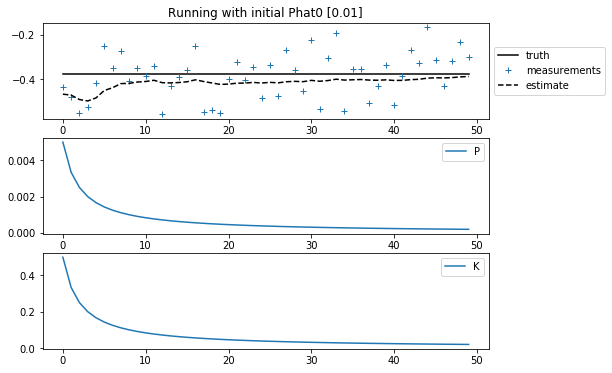

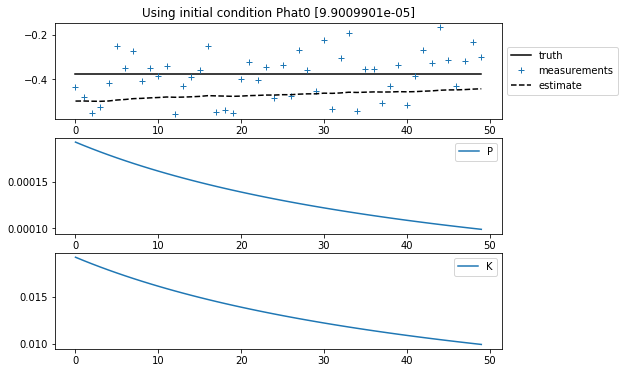

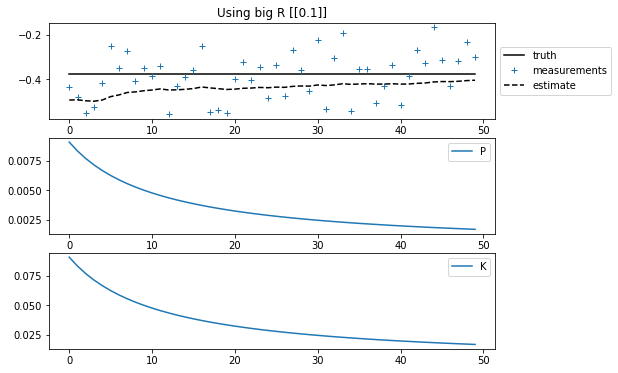

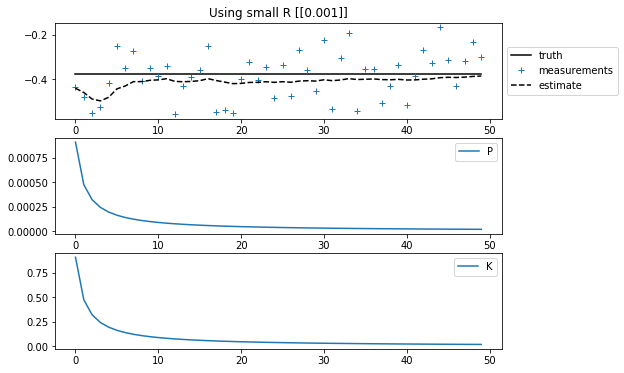

In [3]:
# 1d constant dynamics, no noise
def replicate_introduction():
    """Test that the Kalman filter works on a 1D constant system with no noise"""
    A = np.array([[1]]) # no dynamics, system constant
    B = np.array([[0]]) # no input
    C = np.array([[1]]) # measure state directly
    D = np.array([[0]]) # no pass through
    Q = np.array([[0]]) # no process noise
    R = np.array([[0.01]])
    x0 = np.array([-0.37727])
    xhat0 = np.array([-0.5])
    Phat0 = np.array([0.01])

    N_STEPS = 50
    x = np.zeros(N_STEPS)
    z = np.zeros(N_STEPS)

    # run the underlying LDS
    lds = LDS(A, B, C, D, Q, R, x0)
    for step in range(N_STEPS):
        x[step], z[step] = lds.step(0)
    lds_data = (x, z)
    
    # run the KF
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    kf_xhat = np.zeros((N_STEPS, 1))
    kf_p = np.zeros((N_STEPS, 1))
    kf_k = np.zeros((N_STEPS, 1))
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    kf_data = (kf_xhat, kf_p, kf_k)
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Running with initial Phat0 {}".format(Phat0))
    
    # what if the KF starts from closer to SS initial condition?
    Phat0 = kf_p[-1,:]
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Using initial condition Phat0 {}".format(Phat0))
    
    # what if our measurement noise variance assumption is too big?
    R = np.array([[0.1]])
    Phat0 = np.array([0.01])
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Using big R {}".format(R))
    
    # what if our measurement noise variance assumption is too small?
    R = np.array([[0.001]])
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Using small R {}".format(R))
    
replicate_introduction()
plt.show()

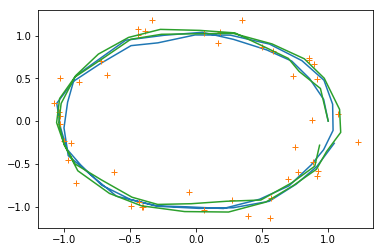

In [4]:
# 2d dyanmics, process + measure noise
def rotation_tracker():
    theta = np.pi/12
    N_STEP = 2*int(2*np.pi/theta)-1

    A = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    B = np.zeros((2, 2))
    C = np.eye(2)
    D = np.zeros((2, 2))
    x0 = np.array([1, 0])
    xhat0 = np.array([1, 0])
    Phat0 = 0.01*np.eye(2)

    Q = 0.001 * np.eye(2)
    R = 0.01 * np.eye(2)

    u = np.zeros(2)

    lds = LDS(A, B, C, D, Q, R, x0)
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    lds_data, kf_data = run_lds_kf(lds, kf, N_STEP, u=u)
    x, z = lds_data
    xhat, p, k = kf_data
    plt.plot(x[:, 0], x[:, 1])
    plt.plot(z[:, 0], z[:, 1], "+")
    plt.plot(xhat[:, 0], xhat[:, 1])
    plt.show()
rotation_tracker()    